In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# The Beginning

I started this project as I became slightly obsessed with a game mechanic in an RPG that I was running called [Open Legend RPG](https://openlegendrpg.com/).

In this game, every roll that you make has the ability to explode. That means that whenever ANY die rolls maximum, you get to reroll it and add the new roll to your total, ad infinitum.

In example, if you rolled at 6 sided die (d6) and landed on a 6 you would roll again. Let's say you landed on another 6, you would roll again. Then you landed on a 1. Your roll is over, but in total you would have $6+6+1=13$ as your total for that 6 sided die.

# The Question
Initially, I just assumed that a die with larger number of sides would be simply better than a die with fewer sides. After thinking about this, however, I realized that this may not be true. Let's say you use a 4 sided die and a 6 sided die. You have a $\frac{1}{4}$ probability of exploding with the 4 sided die and $\frac{1}{6}$ probability of exploding on a 6 sided die. Could the higher probability of explosions lead to a higher expected outcome?

Well, in the case of a 1 sided die, you would roll that die forever adding up 1 repeatedly until infinity. While my intuition is that this does not generalize to dice with more faces, I felt the need to explore it a bit more.

# Expected Value
I wanted to look at the long run behavior of various dice to see if a larger die was always better.

I ended up coming up with a quick formulation for expected value as follows:

Let $S_n$ be the value of rolling of an exploding $n$-sided die. Also, let $x$ be the the value of one roll individual. Using union of disjoint events, we end up with this:

$E(S_n)= \textrm{Expected value of the die given it did not explode} + \textrm{Expected value of the die given it did explode}$

$E(S_n)=Pr(x<n)\cdot E(S_n|x<n)+ Pr(x=n)E(S_N|x=n)$

The probability that you roll less than $n$ on a single roll is $1-\frac{1}{n}$.

The expected value of that die is $\frac{1}{n-1}1+\frac{1}{n-1}2+\frac{1}{n-1}3+\frac{1}{n-1}4+...+\frac{1}{n-1}(n-1)=\frac{1}{n-1}\sum_{i=1}^{n-1} i=\frac{(n-1)(n)}{2(n-1)}=\frac{n}{2}$.


The probability that the die explodes is $\frac{1}{n}$.
The expected value of the explosions is $n+E(S_n)$.

Now we have the full equation for the expected value:

$E(S_n)=(1-\frac{1}{n})(\frac{n}{2})+(\frac{1}{n})(n+E(S_n))$

After some algebra, we end up with:

$E(S_n)=\frac{n(n+1)}{2(n-1)}$

As $n$ increases, we see that $E(S_n)$ also increases.

In [4]:
def expected(n):
    return (n)*(n+1)/(2*(n-1))

In [5]:
expected_values = [(n,expected(n)) for n in np.arange(2,20)]

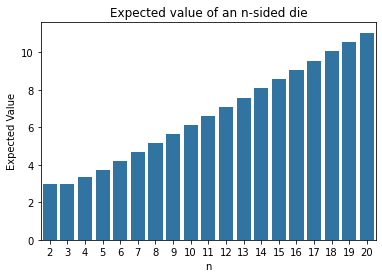

In [43]:
ax = sns.barplot(x=np.arange(2,21), y=[expected(i) for i in np.arange(2,21)], color = "#1f77b4")
ax.set(xlabel="n", ylabel = "Expected Value",title = "Expected value of an n-sided die");

This looks like it is increasing to me. Let's check with larger values.

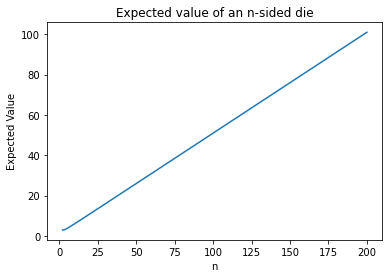

In [7]:
ax = sns.lineplot(x=np.arange(2,201), y=[expected(i) for i in np.arange(2,201)])
ax.set(xlabel="n", ylabel = "Expected Value",title = "Expected value of an n-sided die");

## Empirical testing of expected value
This is a Jupyter Notebook for a reason. Let's test our formula and see how correct it is. First, let's write some code for empirical testing the value of an $n$-sided die.

In [8]:
# Count is the number of dies rolled.
# Sides is the number of sides for the die.
# Returns a list of results on each die.
def roll(count, sides):
    if not (count and sides) or not (count + sides) % 1 == 0:
        raise ValueError("Count and sides must be a positive integer.")
    roll = [np.random.randint(1, sides + 1) for _ in np.arange(count)]
    for i in np.arange(0,count):
        while roll[i] % sides == 0:
            roll[i] += np.random.randint(1, sides + 1)
    return roll

In [9]:
roll(12,6)

[4, 4, 3, 5, 5, 3, 3, 3, 4, 5, 4, 2]

Now lets compare the average dice roll to the expected value that we calculated earlier.

In [10]:
np.average(roll(10000,6))

4.165

In [11]:
expected(6)

4.2

That seems really close to me! Looks like the more sides a die has, the higher the expected value! This is worth bootstrapping and running a test, though I am moving on for now.

# A Wrinkle in My Plan: Rolling in a game doesn't care about expected values

After I was satisfied that rolling a d8 is better than a d6, I realized something in weird edge cases.

The only thing that matters is whether or not your roll is larger than a specific given value. Let's check out a strange case:

If you wanted to roll higher than an 8, would you rather roll a d6 or a d8?

Well, the probability of beating that score with a d8 is $\frac{1}{8}$. To beat it with a d6, you need to first explode (probability $\frac{1}{6}$), and then roll 2 or better (probability $\frac{5}{6}$. The probability of getting an 8 or better with a d6 is thus $\frac{1}{6}\cdot \frac{5}{6}=\frac{5}{36}$. That is higher than the probability to beat it with a d8. $\frac{1}{8}<\frac{5}{36}$

If you want to get a score of 8 or higher, you would prefer to roll a d6 than a d8.

So let's begin exploration of this idea!

Let's say you are working with a $n$-sided die. Let's look at the probability of rolling $DC$ (difficulty check) or higher.

If $DC<=n$, then the probability of rolling greater than $DC$ is $\frac{n+1-DC}{n}$. If you want to roll 1 or higher on a d6, then you will do so with probability 1. If you want to roll 4 or higher on a d6, that would be $\frac{6+1-4}{6}=\frac{3}{6}=\frac{1}{2}=0.5$. Intuitively, this means you can roll 4, 5, or 6.



What makes this complicated is the exploding part of the die. Let's start decomposing the problem. Any specific number can be rolled only 1 way. It can be decomposed in this way:

$$Value = (\textrm{# of explosions}) * (n) + (\textrm{The final die roll})$$

If you wanted to roll a value of 8 on a d6, you require 1 explosion and then must roll 2 or higher. If you want to beat a check of 37, the die has to explode 6 times, then you can roll any die. Mathmatically, you can conceptualize this with the following formula.

The probability of beating a diffculty check is thus:

$$Pr(S_n\geq DC)=Pr(\textrm{Getting e number of explosions}) * Pr(\textrm{rolling higher than the remainder})$$

If $n \mod DC \neq 0$
$$Pr(S_n\geq DC)=\frac{1}{n}^{\lfloor \frac{DC}{n}\rfloor} * \frac{n+1-(n \mod{DC})}{n}$$

If $n \mod DC = 0$
$$Pr(S_n\geq DC)=\frac{1}{n}^{\lfloor \frac{DC}{n}\rfloor} $$

This leaves us with an unfortunate piecewise function, however, it does make sense. The probability of rolling exactly a number that is divisible by $n$ is 0. In example, there is no way to roll a 6 or a d6 with when accounting for explosions.

Now, let's try visualizing what this looks like

In [12]:
def prob_beat_dc(dc, sides):    
    if dc % sides == 0:
        return (1/sides) ** np.floor(dc/sides)
    else:
        return (1/sides) ** np.floor(dc/sides) * (sides + 1 - (dc % sides)) / sides

In [13]:
for dc, sides in ((1,6), (2,6), (6,6), (7,6), (8,6), (7,8), (8,8)):
    print(f"P(Win|DC={dc},Sides={sides}) = {prob_beat_dc(dc,sides)}")

P(Win|DC=1,Sides=6) = 1.0
P(Win|DC=2,Sides=6) = 0.8333333333333334
P(Win|DC=6,Sides=6) = 0.16666666666666666
P(Win|DC=7,Sides=6) = 0.16666666666666666
P(Win|DC=8,Sides=6) = 0.13888888888888887
P(Win|DC=7,Sides=8) = 0.25
P(Win|DC=8,Sides=8) = 0.125


Now that we can easily calculate the probability of beating a DC given the die, let's create that plot!

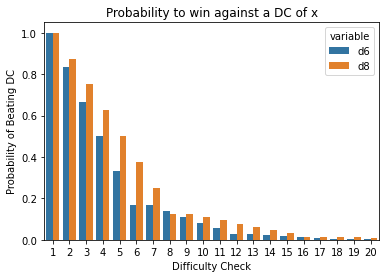

In [14]:
minimum = 1
maximum = 20

x = np.arange(minimum, maximum + 1)
y_1 = [prob_beat_dc(dc, 6) for dc in x]
y_2 = [prob_beat_dc(dc, 8) for dc in x]


df = pd.DataFrame({"dc" : x, "d6" : y_1, "d8" : y_2})
df = pd.melt(df, id_vars=['dc'])
sns.barplot(data = df, x = "dc", y = "value", hue = "variable")
plt.title("Probability to win against a DC of x")
plt.xlabel("Difficulty Check")
plt.ylabel("Probability of Beating DC");

Interesting! We see that the only time that a d6 is better than a d8 is on the difficulty check of 8.

Looking at this, closer, we also see that 16 seems awfully close too. That is also a multiple of 8. Perhaps there is something there to investigate...

In [15]:
for i in np.arange(1,100 + 1):
    if prob_beat_dc(i, 6) > prob_beat_dc(i, 8):
        print(f"DC {i}: {prob_beat_dc(i, 6)} > {prob_beat_dc(i, 8)}")

DC 8: 0.13888888888888887 > 0.125


In [16]:
print(prob_beat_dc(16, 6), prob_beat_dc(16, 8))

0.013888888888888888 0.015625


Looks like it is fairly close, but a d8 is still slightly better than a d6. It looks like there are very niche scenarios in which the lower die is better. Another case is when the DC is 6, a d4 is better than a d6. It is also possible a d8 is better than a d10 for dc 10.

Overall, the mechanic seems to be fairly balanced. Expectation rises, but not too much. It allows for rare, surprising moments. It also is balanced so that a higher die is still better than a lower one at all reasonable points (as a difficulty check of 8, 6, or other low values is exceedingly odd).

# Rolling Multiple Dice

## Expectation
The expectation of rolling multiple dice is simple to compute use the above formulas. As each die roll is independent and added together, you can simply sum their expectations.

In [17]:
print("Expectation of D20 + D6:",expected(20) + expected(6))
print("Expectation of D8 + D6:",expected(8) + expected(6))
print("Expectation of D20 + D8:",expected(20) + expected(8))
print("Expectation of D20 + 2D6:",expected(20) + 2 * expected(6))

Expectation of D20 + D6: 15.25263157894737
Expectation of D8 + D6: 9.342857142857143
Expectation of D20 + D8: 16.195488721804512
Expectation of D20 + 2D6: 19.45263157894737


## Distribution

Here, it's not quite as simple as the last calculation. There are multiple dice and inconsistent probabilities, however we should make quick work of this through the power of python!

Each value can be rolled a number of ways. If $S$ is the sum of $X_1$ and $X_2$ (the result of rolling two dice), then the probability that $S=k$ is equal to all the ways that $X_1$ and $X_2$ can sum to $k$. That is, it is the probability that $X_1 = n$ and $X_2 = k-n$.

In [38]:
def prob_exactly(k, die):
    if k % die == 0:
        return 0
    else:
        return ((1/die) ** np.floor(k/die)) * (1 / die)   
        
def mult_die_prob(S, dice):
    # Recursion used to expand this out to any number of dice!
    result = 0
    for k in np.arange(1, S):
        if len(dice) == 2:
            result += prob_exactly(k, dice[0]) * prob_exactly(S - k, dice[-1])
        else:
            result += mult_die_prob(k, dice[:-1]) * prob_exactly(S - k, dice[-1])            
    return result

In [39]:
mult_die_prob(7,(6,6))

0.1111111111111111

In [42]:
mult_die_prob(7,(3,3))

0.07407407407407407

At first I though I had this wrong because I know the probability for rolling a 7 on two normal d6s is 16.67%. I then realized that it definitely had to be lower because you cannot roll a 6 and a 1 or a 1 and a 6 with exploding dice.

Let's graph some distributions!

C:\ProgramData\Miniconda3\lib\site-packages\seaborn\axisgrid.py:645: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


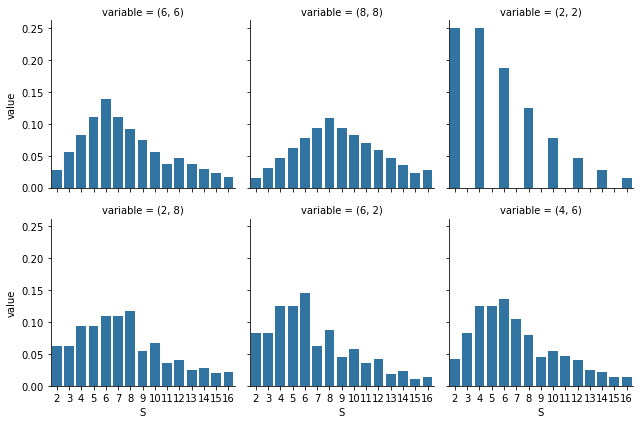

In [87]:
dice_set = ((6,6),(8,8), (2,2), (6,6), (2,8), (6,2), (4,6))
maximum = 16
S = np.arange(2, maximum + 1)

df = pd.DataFrame({"S" : S})
for dice in dice_set:
    y = [mult_die_prob(s, dice) for s in S]
    df[dice] = y

df = pd.melt(df, "S")
g = sns.FacetGrid(df, col="variable", col_wrap=3)
g.map(sns.barplot, "S", "value");


These distributions are a bit unpredictable. This is especially true if the two dice don't match or if one of the dice is very low. I was particularly fascinated by the distribution of two 2 sided dice. It looks like it can only roll even numbers. I then realized that this had to be true. No matter what, the last roll on both dice must be 1. All previous roll would have been even, so the sum must be even.